# Concrete strength prediction

This notebook predicts concrete strength for the Playground Series Season 3 Episode 9 competition:
- Feature engineering is derived from the [EDA which makes sense](https://www.kaggle.com/code/ambrosm/pss3e9-eda-which-makes-sense).
- `AgeInDays` is target-encoded as if it were a categorical variable.
- The original data is not used.
- The final model is a blend of `GradientBoostingRegressor`, `LGBMRegressor`, `RandomForestRegressor` and `Ridge`.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime, lightgbm, math, itertools

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, GroupKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

np.set_printoptions(linewidth=150, edgeitems=5)
result_list = []

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e9/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s3e9/test.csv', index_col='id')
# original = pd.read_csv('/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv')
# original.rename(columns={"CementComponent ": "CementComponent"}, inplace=True)

target = 'Strength'
original_features = list(test.columns)

print(f"Length of train: {len(train)}")
print(f"Length of test:  {len(test)}")
# print(f"Length of original: {len(original)}")
print()

temp1 = train.isna().sum().sum()
temp2 = test.isna().sum().sum()
if temp1 == 0 and temp2 == 0:
    print('There are no null values in train and test.')
else:
    print(f'There are {temp1} null values in train')
    print(f'There are {temp2} null values in train')
print()

print('Sample lines from train:')
train.tail(3)

Length of train: 5407
Length of test:  3605

There are no null values in train and test.

Sample lines from train:


,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
id,,,,,,,,,
5404,295.8,0.0,0.0,185.7,0.0,1076.2,759.3,28,39.30
5405,376.0,93.4,0.0,162.6,11.5,955.8,662.9,28,39.61
5406,190.7,0.0,125.2,166.6,7.9,1079.0,770.1,56,63.14


# Feature engineering

In [3]:
for df in [train, test]:
#     df['Water_Cement'] = df['WaterComponent']/df['CementComponent'] # useless
#     df['Aggregate'] = df['CoarseAggregateComponent'] + df['FineAggregateComponent'] # useless
#     df['Aggregate_Cement'] = df['Aggregate']/df['CementComponent'] # useless
#     df['Slag_Cement'] = df['BlastFurnaceSlag']/df['CementComponent'] # useless
#     df['Ash_Cement'] = df['FlyAshComponent']/df['CementComponent'] # useless
#     df['Plastic_Cement'] = df['SuperplasticizerComponent']/df['CementComponent'] # useless
    df['Age_Water'] = df['AgeInDays'] / df['WaterComponent']
    df['Age_Cement'] = df['AgeInDays'] / df['CementComponent']
    df['Coarse_Fine'] = df['CoarseAggregateComponent'] / df['FineAggregateComponent']
    df['youngCementComponent'] = df.CementComponent * (df.AgeInDays < 40)
    df['youngSuperplasticizerComponent'] = df.SuperplasticizerComponent * (df.AgeInDays < 10)
    df['clippedAge'] = df.AgeInDays.clip(None, 40)
    df['clippedWater'] = df.WaterComponent.clip(195, None)
    df['hasBlastFurnaceSlag'] = df.BlastFurnaceSlag != 0
    df['hasFlyAshComponent'] = df.FlyAshComponent != 0
    df['hasSuperplasticizerComponent'] = df.SuperplasticizerComponent != 0
    

In [4]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Encodes the AgeInDays values by their average target value"""
    def fit(self, X, y):
        # VotingRegressor forwards y as an array
        if type(y) == np.ndarray:
            y = pd.Series(y, index=X.index)
        self.encodings_ = y.groupby(X['AgeInDays'].apply(self.replace_rare)).mean()
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X['AgeInDays'] = self.encodings_.reindex(X['AgeInDays'].apply(self.replace_rare)).values
        return X

    @staticmethod
    def replace_rare(x):
        """Replace the rare AgeInDays values by nearby values"""
        if x == 1: return 3
        if x == 11: return 14
        if x == 49: return 56
#         if x == 91: return 90
#         if x == 120: return 100
        if x == 360: return 365
        return x



# Cross-validation

In [5]:
def score_model(model, features_used, label=None):
    """Cross-validate a model with selected features"""
    score_list = []
    oof = np.zeros_like(train[target])
    kf = KFold(shuffle=True, random_state=333)
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train,
                                                     groups=train[original_features].apply(tuple, axis=1))):
        X_tr = train.iloc[idx_tr][features_used]
        X_va = train.iloc[idx_va][features_used]
        y_tr = train.iloc[idx_tr][target]
        y_va = train.iloc[idx_va][target]
        
#         X_tr = pd.concat([X_tr, original[features_used]], axis=0)
#         y_tr = pd.concat([y_tr, original[target]], axis=0)
        
        model.fit(X_tr, y_tr)
        trmse = mean_squared_error(y_tr, model.predict(X_tr), squared=False)
        y_va_pred = model.predict(X_va)
        rmse = mean_squared_error(y_va, y_va_pred, squared=False)
        if type(model) == Pipeline and type(model.steps[-1][1]) == Ridge:
            print('Weights:', model.steps[-1][1].coef_.round(2))
        print(f"Fold {fold}: trmse = {trmse:.3f}   rmse = {rmse:.3f}")
        oof[idx_va] = y_va_pred
        score_list.append(rmse)

    rmse = sum(score_list) / len(score_list)
    print(f"Average rmse: {rmse:.3f} {label if label is not None else ''}")
    if label is not None:
        global result_list
        result_list.append((label, rmse, oof))
    idxs = np.argsort(oof)
    oof_i = oof[idxs]
    y_true_i = train[target].iloc[idxs]
    s = pd.Series(y_true_i.values, index=oof_i)
    s = s.rolling(100, center=True).mean()
    plt.figure(figsize=(10, 4))
    ax = plt.subplot(1, 2, 1) # y_true vs. y_pred
    plt.scatter(oof, train[target], s=3)
    ax.scatter(s.index, s, s=2, c='r')
    ax.plot([s.index.min(), s.index.max()], [s.index.min(), s.index.max()], c='y', lw='2')
    ax.set_aspect('equal')
    ax.set_xlabel('y_pred')
    ax.set_ylabel('y_true')
    plt.subplot(1, 2, 2) # histogram
    plt.hist(oof, bins=100)
    plt.xlabel('y_pred')
    plt.ylabel('count')
    plt.show()


Weights: [ 2.85  0.93 -1.31  0.68  1.11 -1.02  6.23  0.89  0.8   0.74 -1.55  4.73  0.8   0.73]
Fold 0: trmse = 12.026   rmse = 12.426
Weights: [ 2.69  0.52 -1.59  0.27  1.32 -1.21  6.39  1.34  1.    1.09 -2.12  4.72  0.99  0.88]
Fold 1: trmse = 12.029   rmse = 12.449
Weights: [ 2.85  0.79 -1.29  0.26  1.14 -0.85  6.26  1.    0.95  0.79 -1.47  4.67  0.8   0.83]
Fold 2: trmse = 12.199   rmse = 11.737
Weights: [ 2.77  0.64 -1.41  0.06  1.29 -1.27  6.16  1.07  1.19  0.97 -2.31  4.83  0.84  0.95]
Fold 3: trmse = 12.174   rmse = 11.848
Weights: [ 2.83  0.78 -1.63  0.23  0.7  -0.84  6.27  0.92  0.87  0.97 -1.24  4.72  0.93  0.86]
Fold 4: trmse = 12.067   rmse = 12.288
Average rmse: 12.150 Ridge


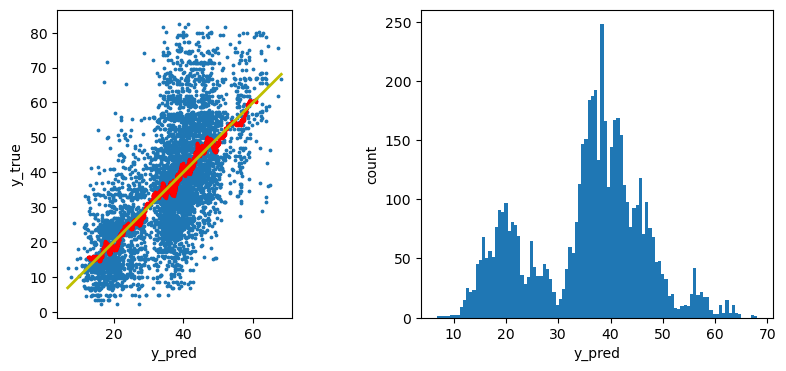

In [6]:
ridge_features = ['CementComponent', 'BlastFurnaceSlag', 'WaterComponent', 'SuperplasticizerComponent',
                     'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays', 'hasBlastFurnaceSlag',
                     'hasSuperplasticizerComponent', 'clippedWater', 'Coarse_Fine', 'clippedAge',
                     'youngCementComponent', 'youngSuperplasticizerComponent'
                    ]
score_model(model=make_pipeline(TargetEncoder(), StandardScaler(), Ridge(30)),
            features_used=ridge_features,
            label='Ridge')

Fold 0: trmse = 11.310   rmse = 12.527
Fold 1: trmse = 11.360   rmse = 12.337
Fold 2: trmse = 11.519   rmse = 11.689
Fold 3: trmse = 11.506   rmse = 11.716
Fold 4: trmse = 11.389   rmse = 12.220
Average rmse: 12.098 Random Forest


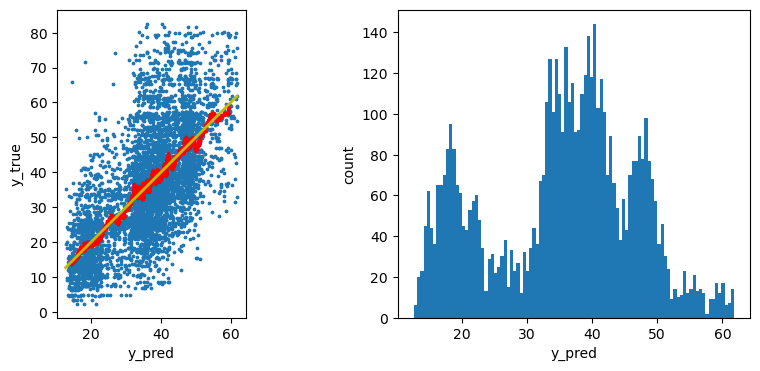

CPU times: user 16.1 s, sys: 206 ms, total: 16.3 s
Wall time: 16.1 s


In [7]:
%%time
rf_features = original_features + ['Age_Water', 'Age_Cement']
score_model(model=make_pipeline(TargetEncoder(), RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=1)),
            features_used=rf_features,
            label='Random Forest')

Fold 0: trmse = 11.462   rmse = 12.487
Fold 1: trmse = 11.524   rmse = 12.305
Fold 2: trmse = 11.669   rmse = 11.647
Fold 3: trmse = 11.648   rmse = 11.752
Fold 4: trmse = 11.530   rmse = 12.207
Average rmse: 12.080 LGBM


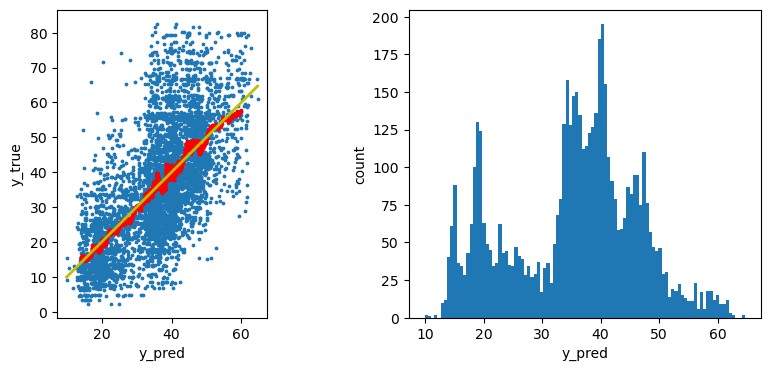

CPU times: user 3min 28s, sys: 1min 29s, total: 4min 57s
Wall time: 2min 40s


In [8]:
%%time
lgbm_params = {
        'learning_rate': 0.0005,
        'n_estimators': 20000,
        'num_leaves': 7,
        'colsample_bytree': 0.4,
        'subsample': 0.5,
        'subsample_freq': 6,
        'min_child_samples': 25,
    }

score_model(model=lightgbm.LGBMRegressor(**lgbm_params, random_state=1),
            features_used=original_features,
            label='LGBM')


Fold 0: trmse = 11.424   rmse = 12.484
Fold 1: trmse = 11.517   rmse = 12.293
Fold 2: trmse = 11.641   rmse = 11.589
Fold 3: trmse = 11.624   rmse = 11.709
Fold 4: trmse = 11.524   rmse = 12.215
Average rmse: 12.058 GradientBoostingRegressor


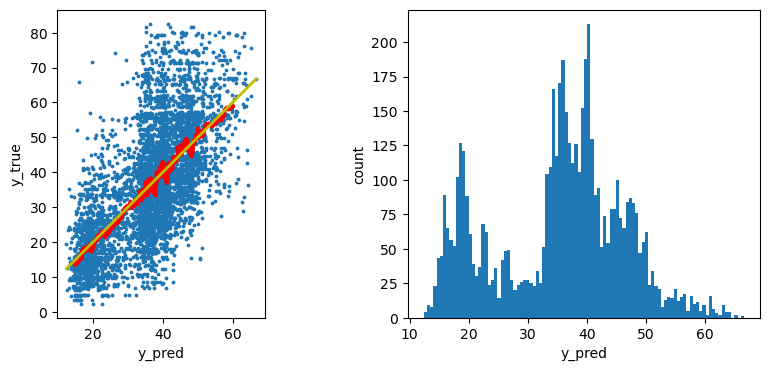

In [9]:
gbr_params = {'n_estimators': 600,
              'max_depth': 4,
              'learning_rate': 0.01,
              'min_samples_leaf': 40 ,
              'max_features': 3}
score_model(model=make_pipeline(TargetEncoder(), GradientBoostingRegressor(**gbr_params, random_state=2)),
            features_used=original_features,
            label='GradientBoostingRegressor')



# Ensemble

Fold 0: trmse = 11.527   rmse = 12.398
Fold 1: trmse = 11.587   rmse = 12.302
Fold 2: trmse = 11.733   rmse = 11.601
Fold 3: trmse = 11.715   rmse = 11.691
Fold 4: trmse = 11.607   rmse = 12.182
Average rmse: 12.035 GradientBoostingRegressor + RF + Ridge


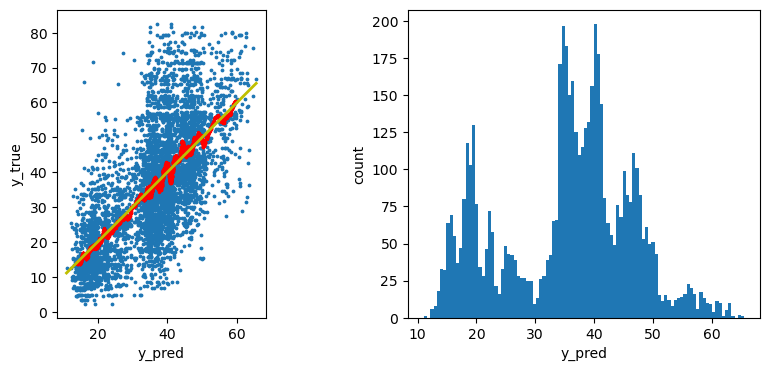

CPU times: user 27.6 s, sys: 3.19 s, total: 30.7 s
Wall time: 25.1 s


In [10]:
%%time
ensemble_model = VotingRegressor([('gb', make_pipeline(TargetEncoder(),
                                                       ColumnTransformer([('pt', 'passthrough', original_features)]),
                                                       GradientBoostingRegressor(**gbr_params, random_state=1))),
                                  ('rf', make_pipeline(TargetEncoder(),
                                                       ColumnTransformer([('pt', 'passthrough', rf_features)]),
                                                       RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=1))),
                                  ('ridge', make_pipeline(TargetEncoder(),
                                                          ColumnTransformer([('pt', 'passthrough', ridge_features)]),
                                                          StandardScaler(),
                                                          Ridge(30))),
                                 ],
                                 weights=[0.35, 0.3, 0.35])
score_model(model=ensemble_model,
            features_used=test.columns,
            label='GradientBoostingRegressor + RF + Ridge')

Fold 0: trmse = 11.502   rmse = 12.401
Fold 1: trmse = 11.558   rmse = 12.294
Fold 2: trmse = 11.709   rmse = 11.599
Fold 3: trmse = 11.689   rmse = 11.689
Fold 4: trmse = 11.578   rmse = 12.172
Average rmse: 12.031 GradientBoostingRegressor + LGBM + RF + Ridge


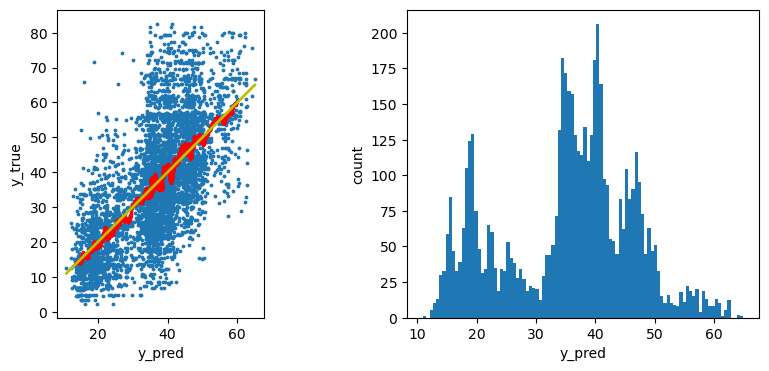

CPU times: user 4min 5s, sys: 1min 41s, total: 5min 46s
Wall time: 3min 18s


In [11]:
%%time
ensemble_model = VotingRegressor([('gb', make_pipeline(TargetEncoder(),
                                                       ColumnTransformer([('pt', 'passthrough', original_features)]),
                                                       GradientBoostingRegressor(**gbr_params, random_state=1))),
                                  ('lgbm', make_pipeline(ColumnTransformer([('pt', 'passthrough', original_features)]),
                                                         lightgbm.LGBMRegressor(**lgbm_params, random_state=1))),
                                  ('rf', make_pipeline(TargetEncoder(),
                                                       ColumnTransformer([('pt', 'passthrough', rf_features)]),
                                                       RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=1))),
                                  ('ridge', make_pipeline(TargetEncoder(),
                                                          ColumnTransformer([('pt', 'passthrough', ridge_features)]),
                                                          StandardScaler(),
                                                          Ridge(30))),
                                 ],
                                 weights=[0.2, 0.2, 0.3, 0.3])
score_model(model=ensemble_model,
            features_used=test.columns,
            label='GradientBoostingRegressor + LGBM + RF + Ridge')

# Final comparison

In [12]:
result_df = pd.DataFrame(result_list, columns=['label', 'rmse', 'oof'])
result_df.drop_duplicates(subset='label', keep='last', inplace=True)

,label,rmse
5,GradientBoostingRegressor + LGBM + RF + Ridge,12.031
4,GradientBoostingRegressor + RF + Ridge,12.035
3,GradientBoostingRegressor,12.058
2,LGBM,12.080
1,Random Forest,12.098
0,Ridge,12.150


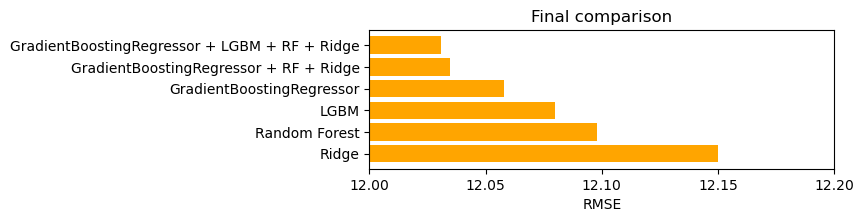

In [13]:
result_df.sort_values('rmse', inplace=True)
with pd.option_context("precision", 3):
    display(result_df[['label', 'rmse']])
plt.figure(figsize=(6, len(result_df) * 0.3))
plt.title('Final comparison')
plt.barh(np.arange(len(result_df)), result_df.rmse, color='orange')
plt.gca().invert_yaxis()
plt.yticks(np.arange(len(result_df)), result_df.label)
plt.xticks(np.linspace(12.0, 12.2, 5))
plt.xlabel('RMSE')
plt.xlim(12.0, 12.2)
plt.show()

# Prediction and submission

In [14]:
%%time
ensemble_model.fit(train[test.columns], train[target])
y_pred = ensemble_model.predict(test[test.columns])
pd.Series(y_pred, index=test.index, name=target).to_csv(f"submission.csv")
y_pred.round(1)

CPU times: user 44.9 s, sys: 18.1 s, total: 1min 2s
Wall time: 36.9 s


array([49.7, 19.6, 34. , 47.5, 33.5, ..., 33.6, 36.5, 40.1, 33.8, 22.2])